# Quaternion convolutional layers reproduction

Firstly I want to check if it possible to recreate the paper. This process will consist of the following steps

- Dataloader
- DataFormatter
- QCNN import 
- QNN import
- Recreate archtitecture 
- Train

# Questions for the following session

- Where does the conversion to quaternions happen
- When we input the output feautures map into the Qlinearlayer we lose all our information right
- Why do de images needed te be padded with a extra dimension

# To do following session

- Train the network

## Modules


In [3]:
import numpy as np
import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import core_qnn as qcnn

## Dataloader

In [4]:
# Tranform data to PyTorch tensore
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

# Download the data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# Define the loaders
train_loader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_testset, batch_size=1000)

# Here we can add some data cleanup

Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([64, 3, 32, 32])


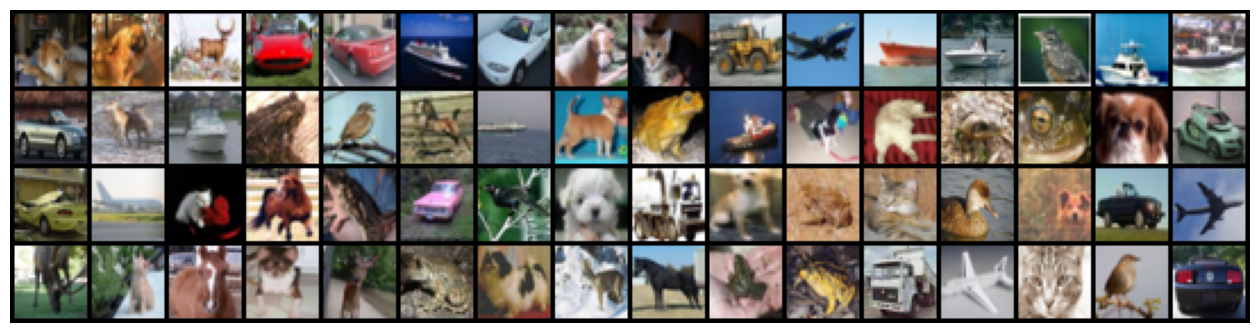

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

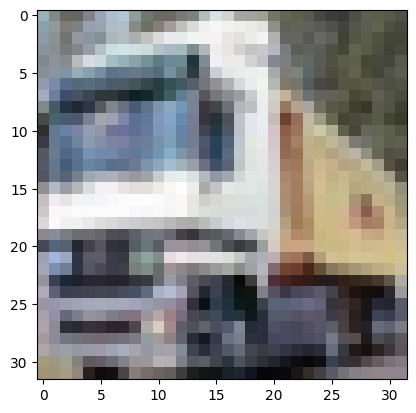

In [6]:
image, label  = cifar_trainset[1] 
plt.imshow(image.view(3,32,32).permute((1, 2, 0)))

## Creating the architecture

In [7]:
import torch
import torch.nn as nn
from   torch.nn import Parameter
from   torch.nn import functional as F
import torch.optim
from   torch.autograd import Variable
from   torch import autograd
import numpy as np

from   core_qnn.quaternion_layers import QuaternionLinear, QuaternionTransposeConv, QuaternionConv


class QAE(nn.Module):

    def __init__(self):
        super(QAE, self).__init__()
        
        self.e1 = QuaternionConv(4, 4, kernel_size=3, stride=2, padding=1)
        self.e2 = QuaternionConv(4, 4, kernel_size=3, stride=2, padding=1)
        self.e3 = QuaternionLinear(256, 10)
        self.act = nn.ReLU()
        self.output_act = nn.Sigmoid() 
        



    def forward(self, x):

        # Format to torch tensor
        x = torch.from_numpy(np.expand_dims(x, axis=0)).float()

        output1 = self.e1( x  )
        output2 = self.e2(output1)
        output3 = self.act(output2)
        output4 = self.e3(output3.view(1,256))
        out = self.output_act(output4)


        return out

    def name(self):
        return "QAE"

## Dataformatter

In [8]:
import os
from   imageio import imread,imwrite
import numpy   as np
import sys

SAMPLES = 10000

NUM_EPOCHS = 30001
LEARNING_RATE = 0.0005

data_placeholder = np.zeros((int(SAMPLES*0.8),4,32,32))
label_placeholder = np.zeros((int(SAMPLES*0.8),))


test_placeholder = np.zeros((int(SAMPLES*0.2),4,32,32))
test_label_placeholder = np.zeros((int(SAMPLES*0.2)+1,))

# Dataformatter
for i in range(SAMPLES):
    images, labels =  train_loader[i]
    if labels > 7: 
        continue

    # This will functino as out "Picture"
    train = images.permute((1, 2, 0))

    # Copied from the online git
    # We are giving it an extra dimension not so sure why
    npad  = ((0, 0), (0, 0), (1, 0))
    train = np.pad(train, pad_width=npad, mode='constant', constant_values=0)
    train = np.transpose(train, (2,0,1))
    train = np.reshape(train, (1, train.shape[0], train.shape[1], train.shape[2]))

    if i >= int(SAMPLES * 0.8):
        i -= int(SAMPLES * 0.8)
        test_placeholder[i] = train
        test_label_placeholder[i] = labels

    data_placeholder[i] = train
    label_placeholder[i] = labels

data_placeholder.shape


TypeError: 'DataLoader' object is not subscriptable

In [7]:
label_placeholder.max()

7.0

# Let's try it with a single picture

In [36]:
import torch.nn.functional as F
# Manual

convulution = QuaternionConv(4, 4, kernel_size=3, stride=1, padding=1)
linear = QuaternionLinear(4096 , 10)

def manual_forward(train):
    output1 = convulution.forward( train  )
    output3 = F.relu(output1)
    output4 = linear.forward(output3.view(1,4096))
    result = F.sigmoid(output4)
    print(result.shape)
    return

manual_forward(torch.from_numpy(np.expand_dims(data_placeholder[2], axis=0)).float() )

torch.Size([1, 8])


## Let's see if the forward works of the function

In [9]:
jap = QAE()

jap.forward(data_placeholder[2])

tensor([[0.6106, 0.4393, 0.3364, 0.6413, 0.4552, 0.4998, 0.5077, 0.6324]],
       grad_fn=<SigmoidBackward0>)

## Training the network (still needs to be done)



In [10]:
# Initialize net 
net = QAE( )

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 8000

losses = []

for epoch in range(NUM_EPOCHS):

    output = net.forward(data_placeholder[epoch])


    index = output[0].argmax()
    
    answer_one_hot = th.Tensor([0,0,0,0,0,0,0,0])
    answer_one_hot[int(label_placeholder[index]) - 1 ] = 1
    
    criterion = nn.MSELoss()

    loss =  criterion(output[0] , answer_one_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().item())

    print("epoch "+str(epoch+1)+", loss_train "+str(loss.cpu().item()))



epoch 1, loss_train 0.2960042357444763
epoch 2, loss_train 0.285015732049942
epoch 3, loss_train 0.27631059288978577
epoch 4, loss_train 0.27996039390563965
epoch 5, loss_train 0.26398321986198425
epoch 6, loss_train 0.28814342617988586
epoch 7, loss_train 0.27961423993110657
epoch 8, loss_train 0.27150702476501465
epoch 9, loss_train 0.2729173004627228
epoch 10, loss_train 0.2609710991382599
epoch 11, loss_train 0.28089067339897156
epoch 12, loss_train 0.2728312015533447
epoch 13, loss_train 0.24806445837020874
epoch 14, loss_train 0.2541431486606598
epoch 15, loss_train 0.24925628304481506
epoch 16, loss_train 0.24986109137535095
epoch 17, loss_train 0.24394895136356354
epoch 18, loss_train 0.24194888770580292
epoch 19, loss_train 0.25789159536361694
epoch 20, loss_train 0.2610357701778412
epoch 21, loss_train 0.23873506486415863
epoch 22, loss_train 0.2411675751209259
epoch 23, loss_train 0.2559282183647156
epoch 24, loss_train 0.25921866297721863
epoch 25, loss_train 0.243229150772

In [11]:
net.forward(data_placeholder[999])

tensor([[8.1599e-10, 3.3705e-09, 9.4521e-09, 1.0000e+00, 2.1755e-06, 3.3227e-06,
         5.9118e-07, 2.7939e-09]], grad_fn=<SigmoidBackward0>)

In [12]:
label_placeholder[999]

5.0

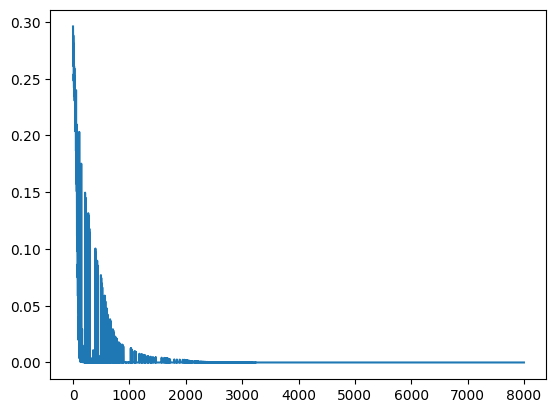

In [13]:
plt.plot(range(0,len(losses)), losses)

In [14]:
peformance =[]


for i in range(int(SAMPLES * 0.2)):

    output = net.forward(test_placeholder[i])

    index = output[0].argmax()

    answer_one_hot = th.Tensor([0,0,0,0,0,0,0,0])
    answer_one_hot[int(test_label_placeholder[index]) - 1 ] = 1

    criterion = nn.MSELoss()

    loss =  criterion(output[0] , answer_one_hot)
    peformance.append(loss.cpu().item())
    

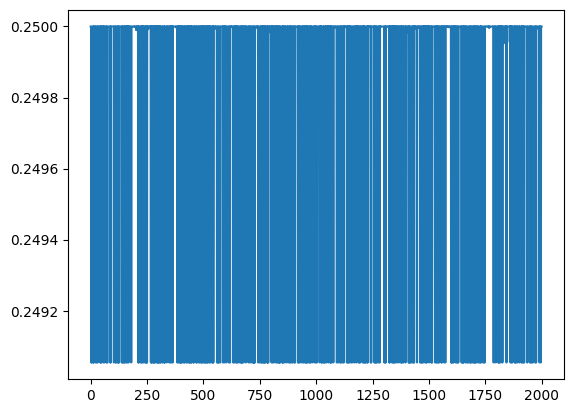

In [15]:
plt.plot(range(0,len(peformance)), peformance)

In [16]:
peformance = np.array(peformance)

print(len(peformance[peformance > 0.1]))

2000


In [17]:
41 / 2000

0.0205